# Requirements

In [1]:
%%capture
!git lfs install
!pip install datasets
!pip install accelerate
!pip install bitsandbytes
!pip install trl

In [2]:
from datasets import load_dataset

dataset = load_dataset("turkish_product_reviews")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/235165 [00:00<?, ? examples/s]

In [3]:
dataset.keys()

dict_keys(['train'])

In [4]:
print(dataset["train"].features)

print(dataset["train"][0])

{'sentence': Value(dtype='string', id=None), 'sentiment': ClassLabel(names=['negative', 'positive'], id=None)}
{'sentence': 'fena değil paraya göre iyi.', 'sentiment': 1}


In [5]:
df = dataset["train"].to_pandas()

# Imports

In [6]:
import pandas as pd
import torch

# EDA

## Checking data quality

In [7]:
df

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
...,...,...
235160,odada bu buhar makinası çalışırken uyumak kesi...,0
235161,ürün gayet güzel ve sağlam.tek kusuru sesli ça...,0
235162,hepsiburadaya tesekkurler,0
235163,çok ufak ve basit plastikten yapılmış. hiç kul...,0


In [8]:
def check_data(data):
  null_data = data.isna().sum()
  null_percentage = data.isna().sum() / len(data)
  null_percentage = null_percentage.apply(lambda x: f"{x:.1%}")
  print("Duplicated data: ", data.duplicated().sum())
  result = pd.concat([null_data, null_percentage], axis=1)
  result.columns = ["Null Data", "Null Percentage"]
  return result
check_data(df)

Duplicated data:  1580


,Null Data,Null Percentage
sentence,0,0.0%
sentiment,0,0.0%


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
...,...,...
235160,odada bu buhar makinası çalışırken uyumak kesi...,0
235161,ürün gayet güzel ve sağlam.tek kusuru sesli ça...,0
235162,hepsiburadaya tesekkurler,0
235163,çok ufak ve basit plastikten yapılmış. hiç kul...,0


In [11]:
import pandas as pd
import string

def has_uppercase(data):
    return any(char.isupper() for char in data)

def has_punctuation(data):
    if isinstance(data, str):
        return any(char in string.punctuation for char in data)
    else:
        return False

def has_digit(data):
    return any(char.isdigit() for char in data)

def has_special_char(data):
    special_chars = []
    for char in data:
        if not char.isalnum():
            special_chars.append(char)
    return len(special_chars) > 0

def is_any_condition(df):
    counter = 0
    has_uppercase_counter = 0
    has_punctuation_counter = 0
    has_digit_counter = 0
    has_special_char_counter = 0

    for index, row in df.iterrows():
        counter += 1
        if isinstance(row, str):
            if has_uppercase(row):
                has_uppercase_counter += 1
            if has_punctuation(row):
                has_punctuation_counter += 1
            if has_digit(row):
                has_digit_counter += 1
            if has_special_char(row):
                has_special_char_counter += 1

    return (f"Checked: {counter} of {len(df)}, "
            f"has_uppercase_counter: {has_uppercase_counter}, "
            f"has_punctuation_counter: {has_punctuation_counter}, "
            f"has_digit_counter: {has_digit_counter}, "
            f"has_special_char_counter: {has_special_char_counter}")
print(is_any_condition(df))

Checked: 233585 of 233585, has_uppercase_counter: 0, has_punctuation_counter: 0, has_digit_counter: 0, has_special_char_counter: 0


In [12]:
# for index, word in enumerate(special_chars[:50]):
#   print(f"{index}: {word}, ")

## Cleaning sentences

In [13]:
import string
import re
from collections import defaultdict

def clean_punctuation(sentence):
  if isinstance(sentence, str):
    return sentence.translate(str.maketrans('', '', string.punctuation))

def listToString(text):
    str1 = ""
    return (str1.join(text))

def clean_url(sentence):
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    sentence = pattern_url.sub('',sentence)
    return sentence

def clean_email(sentence):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    sentence = str(sentence)
    sentence = pattern_email.sub('',sentence)
    return sentence

def start_preprocessing(sentence):
    sentence = clean_email(sentence)
    sentence = clean_url(sentence)
    sentence = listToString(sentence.split('.'))
    sentence = clean_punctuation(sentence)
    return sentence.strip()

In [14]:
df.sentence[20]

'ev kullanımı için gayet iyi. isı ve üfleme gayet başarılı..'

In [15]:
start_preprocessing(df.sentence[20])

'ev kullanımı için gayet iyi isı ve üfleme gayet başarılı'

In [16]:
cleaned_df = pd.DataFrame(columns=['sentence'], index=df.index)

In [17]:
cleaned_df['sentence'] = df['sentence'].apply(lambda x: start_preprocessing(x))

In [18]:
for index, word in enumerate(cleaned_df.sentence.sample(50)):
  print(f"{index}: {word}")

0: not içinden çıkan plastik hortumu bir şekilde düzleştirebilirseniz işiniz daha kolay hale gelir
1: her zaman olduğu gibi hepsiburada güvencesi ile hızlı şekilde ulaştı
2: oğlumun odasına aldım  oyunlar artık bu koltukta oynanıyor
3: hepsiburadaya hızlı ve sağlam gönderimi için teşekkürlerbraun kesinlikle bu işi biliyor cildim sorunlu olduğu için tereddüt ettim ama iyiki almışım makine çok güzel ve konforlu
4: ürün gayet kolay kuruluyor ve aynen göründüğü gibi ayakları olsa daha kullanışlı olabilir dolap kısımları çok kullanışlı oldu verdiğiniz parayı hak ediyor
5: ürün 1 günde elime gecri en sevindirici tarafı bu zaten kaliteli bir malzeme bu fiyata bu ürün gayet guzel
6: çok küçük ve kullanissiz
7: ürün güzel zamanında teslimat teşekkürler hepsiburada ailesi ve sağlayıcıları
8: birkaç ay önce şuanki fiyattan çok daha düşük bir fiyata burdan aldım
9: kaliteli bir ürün ambalajındaki kilit de iyi düşünülmüş
10: ürünü denemeden yorumlara bakarak aldım ancak bahsedildiği gibi tatlı bir 

In [20]:
is_any_condition(df)

'Checked: 233585 of 233585, has_uppercase_counter: 0, has_punctuation_counter: 0, has_digit_counter: 0, has_special_char_counter: 0'

# TRL Training With 6 Model

## 11. TurkishReviews

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("kmkarakaya/turkishReviews-ds", from_tf=True).to(device)
tokenizer = AutoTokenizer.from_pretrained("kmkarakaya/turkishReviews-ds")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/869 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/498M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the TF 2.0 model and are newly initialized: ['lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/626k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

In [22]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [23]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [24]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_11 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 100,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [25]:
trainer_11_stats = trainer_11.train()

Step,Training Loss
1,10.936600
2,10.934000
3,9.134300
4,6.850300
5,3.807400
6,1.057800
7,0.617000
8,1.053600
9,0.501100
10,0.668500


In [63]:
turkishReviews_log = trainer_11.state.log_history

In [69]:
output_dir = "turkishReviews"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 2048, 'do_sample': True, 'temperature': 0.8}


('turkishReviews/tokenizer_config.json',
 'turkishReviews/special_tokens_map.json',
 'turkishReviews/vocab.json',
 'turkishReviews/merges.txt',
 'turkishReviews/added_tokens.json',
 'turkishReviews/tokenizer.json')

## 9. Model GPT-2 900M

In [33]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("cenkersisman/gpt2-turkish-900m").to(device)
tokenizer = AutoTokenizer.from_pretrained("cenkersisman/gpt2-turkish-900m")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/956k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/414k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [34]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [35]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [36]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_13 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [37]:
trainer_13_stats = trainer_13.train()

Step,Training Loss
1,30.774600
2,29.828600
3,22.889100
4,11.054700
5,0.768700
6,1.376800
7,0.652400
8,0.606500
9,0.458900
10,0.168600


In [118]:
gpt2_900M_log = trainer_13.state.log_history

In [38]:
output_dir = "gpt2_900M"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2_900M/tokenizer_config.json',
 'gpt2_900M/special_tokens_map.json',
 'gpt2_900M/vocab.json',
 'gpt2_900M/merges.txt',
 'gpt2_900M/added_tokens.json',
 'gpt2_900M/tokenizer.json')

## 9. Model GPT-2

In [39]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/585k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [40]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [41]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [42]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_9 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [43]:
trainer_9_stats = trainer_9.train()

Step,Training Loss
1,6.920800
2,7.682000
3,3.829300
4,0.577700
5,0.581800
6,0.382700
7,0.213300
8,0.318300
9,0.293700
10,0.094500


In [65]:
gpt2_log = trainer_9.state.log_history

In [44]:
output_dir = "gpt2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2/tokenizer_config.json',
 'gpt2/special_tokens_map.json',
 'gpt2/vocab.json',
 'gpt2/merges.txt',
 'gpt2/added_tokens.json',
 'gpt2/tokenizer.json')

## 1. Model GPT-2 Large

In [45]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/585k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [46]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [47]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [48]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_1 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [49]:
trainer_1_stats = trainer_1.train()

Step,Training Loss
1,8.156400
2,8.579600
3,0.290000
4,0.677800
5,22.468200
6,5.130500
7,0.367600
8,0.408100
9,7.397900
10,1.146100


In [66]:
gpt2_large_log = trainer_1.state.log_history

In [50]:
output_dir = "gpt2_large"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2_large/tokenizer_config.json',
 'gpt2_large/special_tokens_map.json',
 'gpt2_large/vocab.json',
 'gpt2_large/merges.txt',
 'gpt2_large/added_tokens.json',
 'gpt2_large/tokenizer.json')

## 2. Model GPT-2 Medium

In [51]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2-medium").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-medium")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/946 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/585k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [52]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [53]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [54]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_2 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [55]:
trainer_2_stats = trainer_2.train()

Step,Training Loss
1,13.217300
2,11.749500
3,0.182800
4,1.002900
5,0.677700
6,0.408600
7,0.229200
8,0.318500
9,5.510000
10,0.095800


In [67]:
gpt2_medium_log = trainer_2.state.log_history

In [56]:
output_dir = "gpt2_medium"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2_medium/tokenizer_config.json',
 'gpt2_medium/special_tokens_map.json',
 'gpt2_medium/vocab.json',
 'gpt2_medium/merges.txt',
 'gpt2_medium/added_tokens.json',
 'gpt2_medium/tokenizer.json')

## 7. Model Kanarya

In [57]:
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("asafaya/kanarya-750m").to(device)
tokenizer = AutoTokenizer.from_pretrained("asafaya/kanarya-750m")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, temperature=0.2, device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/589k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/370k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [58]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [59]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233585 [00:00<?, ? examples/s]

In [60]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_7 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 100,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [61]:
trainer_7_stats = trainer_7.train()

Step,Training Loss
1,18.160200
2,17.591300
3,13.621800
4,8.574500
5,1.640700
6,12.539800
7,4.943700
8,1.948300
9,0.743300
10,1.071600


In [125]:
kanarya_log = trainer_7.state.log_history

In [62]:
output_dir = "kanarya"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 2048, 'do_sample': True, 'temperature': 0.8}


('kanarya/tokenizer_config.json',
 'kanarya/special_tokens_map.json',
 'kanarya/vocab.json',
 'kanarya/merges.txt',
 'kanarya/added_tokens.json',
 'kanarya/tokenizer.json')

# Response Residuals

## GPT-2 900M

In [70]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

output_list = []
model = GPT2LMHeadModel.from_pretrained("/content/gpt2_900M")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_900M")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım."


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "gpt2_900M": predicted_sentence})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım. çok satamadım kaliteli Bu gün internetten bir ürün aldım. o evhalde ki her Bu gün internetten bir ürün aldım."en çok daha öncesinde Bu gün internetten bir ürün aldım. kullanışlı aldım bir Bu gün internetten bir ürün aldım. kendimin de var elime Bu gün internetten bir ürün aldım. aldım bu ürünü al Bu gün internetten bir ürün aldım. çok kaliteli bu ürünü Bu gün internetten bir ürün aldım. ben bir an için kullan Bu gün internetten bir ürün aldım. hiç memnun olmadım Bu gün internetten bir ürün aldım. bu ürünün 2 hafta


## GPT-2

In [71]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer


model = GPT2LMHeadModel.from_pretrained("/content/gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım."


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "gpt2": predicted_sentence})

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım. gün içerisinde geldi ertesi gün kargo geldi teşekkür etmek için Bu gün internetten bir ürün aldım. iyi kalite hızlı kargoda özellikle kargodan sonra elinize Bu gün internetten bir ürün aldım. Satıcı geldi ürün aynı şeyi söyledi gün içinde teslim edildi Bu gün internetten bir ürün aldım. kargodan sonra kargoya verildi bugün de çok daha iyi Bu gün internetten bir ürün aldım. 1 adet almıştım bugün gün içinde geldi ürün elime ulaştı Bu gün internetten bir ürün aldım. Piyasada bu ürün tavsiye edebilirim hem küçük de büyük fark Bu gün internetten bir ürün aldım. 5 günde kargo geldi Bu gün internetten bir ürün aldım. bu ürüne ilk olarak küçük ama güzel bir alışveriş olmuş Bu gün internetten bir ürün aldım. 3 gün içinde elime ulaştı en iyisi ürün fiyatı Bu gün internetten bir ürün aldım. bir kaç defa kullandım ve tavsiye ederim


## GPT-2 Large

In [72]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer


model = GPT2LMHeadModel.from_pretrained("/content/gpt2_large")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_large")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım."


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "gpt2_large": predicted_sentence})

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım. ürün güzel güzel gözüküyünce pişman olmayın Bu gün internetten bir ürün aldım. bir hafta önceürendim küçük ama çok sağlam paket Bu gün internetten bir ürün aldım. o kadar pişmanım ki ürün daha çok elime geçti Bu gün internetten bir ürün aldım. ürünü çok güzel olması gibi ve çok küçük olması gibi Bu gün internetten bir ürün aldım. gayet küçük ama pratik pratik güvenli kesinlikle tavsiye ediyorum Bu gün internetten bir ürün aldım.ürün gün içinde aldım ürünü çok güzel bu gün de Bu gün internetten bir ürün aldım. küçük ambalajlı olarak kutu üzerinde uygun bir ürün çok Bu gün internetten bir ürün aldım. ürün gün içinde de bir çok defa kullandım Bu gün internetten bir ürün aldım. çok güzel iyi bi ürün bir gün sonra aldım ürünü Bu gün internetten bir ürün aldım. çok beğenmişler tavsiye ederim her zaman yan


## GPT-2 Medium

In [73]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer


model = GPT2LMHeadModel.from_pretrained("/content/gpt2_medium")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_medium")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım."


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "gpt2_medium": predicted_sentence})

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım. daha 2 günde kullanabildim ürüne bu kadar iyi bir Bu gün internetten bir ürün aldım. daha sonra da bu ürünü aldım Bu gün internetten bir ürün aldım. edge edge edge edge Bu gün internetten bir ürün aldım. çok güzel yeni yıl hediyesi bu ürün bir Bu gün internetten bir ürün aldım. en kalite bantarım Bu gün internetten bir ürün aldım. üründea310 ve s6 ed Bu gün internetten bir ürün aldım. hızlı kargolar için teşekkür g Bu gün internetten bir ürün aldım. kullandıkça ürünü anlayacaksınızirakli Bu gün internetten bir ürün aldım. bir küçük kutuda ürünü hediye etti4 Bu gün internetten bir ürün aldım.urma dışında kalsanız da sipariş


## Kanarya

In [74]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("/content/kanarya")
tokenizer = AutoTokenizer.from_pretrained("/content/kanarya")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım ve"


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "kanarya": predicted_sentence})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım ve çok Bu gün internetten bir ürün aldım ve çok da çok fazlada kullandım zaten hem ve Bu gün internetten bir ürün aldım vein de çok Bu gün internetten bir ürün aldım vein çok 1 çok en Bu gün internetten bir ürün aldım ve Bu gün internetten bir ürün aldım ve sonra bu vede uygun dahaun ama ürün ederim daha Bu gün internetten bir ürün aldım ve yok veli fiyat Bu gün internetten bir ürün aldım veede telefonuma daha kesinlikle bir ürüṅn yok̇ Bu gün internetten bir ürün aldım ve için yok vė Bu gün internetten bir ürün aldım vė


## TurkishReviews-ds

In [75]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("/content/turkishReviews")
tokenizer = AutoTokenizer.from_pretrained("/content/turkishReviews")

# Text generation pipeline'ını oluşturun
text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=num_words)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


text = "Bu gün internetten bir ürün aldım ve"


predicted_sentence = predict_next_words(text, 10)


print("Tahmin edilen cümle:")
print(predicted_sentence)

output_list.append({"instruction": text, "TurkishReviews_ds": predicted_sentence})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tahmin edilen cümle:
Bu gün internetten bir ürün aldım ve iuyor gibi da iyi ve çok Bu gün internetten bir ürün aldım ve Bu gün internetten bir ürün aldım ve veiṅ Bu gün internetten bir ürün aldım ve 3̇edė Bu gün internetten bir ürün aldım ve olarak 3 da 2 daha çok Bu gün internetten bir ürün aldım ve ve de bu Bu gün internetten bir ürün aldım ve Bu gün internetten bir ürün aldım vein daha mayın Bu gün internetten bir ürün aldım vė Bu gün internetten bir ürün aldım vė


In [76]:
response = pd.DataFrame(output_list)

In [82]:
response

,instruction,gpt2_900M,gpt2,gpt2_large,gpt2_medium,kanarya,TurkishReviews_ds
0,Bu gün internetten bir ürün aldım.,"Bu gün internetten bir ürün aldım. çok satamadım kaliteli Bu gün internetten bir ürün aldım. o evhalde ki her Bu gün internetten bir ürün aldım.""en çok daha öncesinde Bu gün internetten bir ürün aldım. kullanışlı aldım bir Bu gün internetten bir ürün aldım. kendimin de var elime Bu gün internetten bir ürün aldım. aldım bu ürünü al Bu gün internetten bir ürün aldım. çok kaliteli bu ürünü Bu gün internetten bir ürün aldım. ben bir an için kullan Bu gün internetten bir ürün aldım. hiç memnun olmadım Bu gün internetten bir ürün aldım. bu ürünün 2 hafta",NaN,NaN,NaN,NaN,NaN
1,Bu gün internetten bir ürün aldım.,NaN,Bu gün internetten bir ürün aldım. gün içerisinde geldi ertesi gün kargo geldi teşekkür etmek için Bu gün internetten bir ürün aldım. iyi kalite hızlı kargoda özellikle kargodan sonra elinize Bu gün internetten bir ürün aldım. Satıcı geldi ürün aynı şeyi söyledi gün içinde teslim edildi Bu gün internetten bir ürün aldım. kargodan sonra kargoya verildi bugün de çok daha iyi Bu gün internetten bir ürün aldım. 1 adet almıştım bugün gün içinde geldi ürün elime ulaştı Bu gün internetten bir ürün aldım. Piyasada bu ürün tavsiye edebilirim hem küçük de büyük fark Bu gün internetten bir ürün aldım. 5 günde kargo geldi Bu gün internetten bir ürün aldım. bu ürüne ilk olarak küçük ama güzel bir alışveriş olmuş Bu gün internetten bir ürün aldım. 3 gün içinde elime ulaştı en iyisi ürün fiyatı Bu gün internetten bir ürün aldım. bir kaç defa kullandım ve tavsiye ederim,NaN,NaN,NaN,NaN
2,Bu gün internetten bir ürün aldım.,NaN,NaN,Bu gün internetten bir ürün aldım. ürün güzel güzel gözüküyünce pişman olmayın Bu gün internetten bir ürün aldım. bir hafta önceürendim küçük ama çok sağlam paket Bu gün internetten bir ürün aldım. o kadar pişmanım ki ürün daha çok elime geçti Bu gün internetten bir ürün aldım. ürünü çok güzel olması gibi ve çok küçük olması gibi Bu gün internetten bir ürün aldım. gayet küçük ama pratik pratik güvenli kesinlikle tavsiye ediyorum Bu gün internetten bir ürün aldım.ürün gün içinde aldım ürünü çok güzel bu gün de Bu gün internetten bir ürün aldım. küçük ambalajlı olarak kutu üzerinde uygun bir ürün çok Bu gün internetten bir ürün aldım. ürün gün içinde de bir çok defa kullandım Bu gün internetten bir ürün aldım. çok güzel iyi bi ürün bir gün sonra aldım ürünü Bu gün internetten bir ürün aldım. çok beğenmişler tavsiye ederim her zaman yan,NaN,NaN,NaN
3,Bu gün internetten bir ürün aldım.,NaN,NaN,NaN,Bu gün internetten bir ürün aldım. daha 2 günde kullanabildim ürüne bu kadar iyi bir Bu gün internetten bir ürün aldım. daha sonra da bu ürünü aldım Bu gün internetten bir ürün aldım. edge edge edge edge Bu gün internetten bir ürün aldım. çok güzel yeni yıl hediyesi bu ürün bir Bu gün internetten bir ürün aldım. en kalite bantarım Bu gün internetten bir ürün aldım. üründea310 ve s6 ed Bu gün internetten bir ürün aldım. hızlı kargolar için teşekkür g Bu gün internetten bir ürün aldım. kullandıkça ürünü anlayacaksınızirakli Bu gün internetten bir ürün aldım. bir küçük kutuda ürünü hediye etti4 Bu gün internetten bir ürün aldım.urma dışında kalsanız da sipariş,NaN,NaN
4,Bu gün internetten bir ürün aldım ve,NaN,NaN,NaN,NaN,Bu gün internetten bir ürün aldım ve çok Bu gün internetten bir ürün aldım ve çok da çok fazlada kullandım zaten hem ve Bu gün internetten bir ürün aldım vein de çok Bu gün internetten bir ürün aldım vein çok 1 çok en Bu gün internetten bir ürün aldım ve Bu gün internetten bir ürün aldım ve sonra bu vede uygun dahaun ama ürün ederim daha Bu gün internetten bir ürün aldım ve yok veli fiyat Bu gün internetten bir ürün aldım veede telefonuma daha kesinlikle bir ürüṅn yok̇ Bu gün internetten bir ürün aldım ve için yok vė Bu gün internetten bir ürün aldım vė,NaN
5,Bu gün internetten bir ürün aldım ve,NaN,NaN,NaN,NaN,NaN,Bu gün internetten bir ürün aldım ve iuyor gibi da iyi ve çok Bu gün internet

# Model Plots

## TurkishReviews

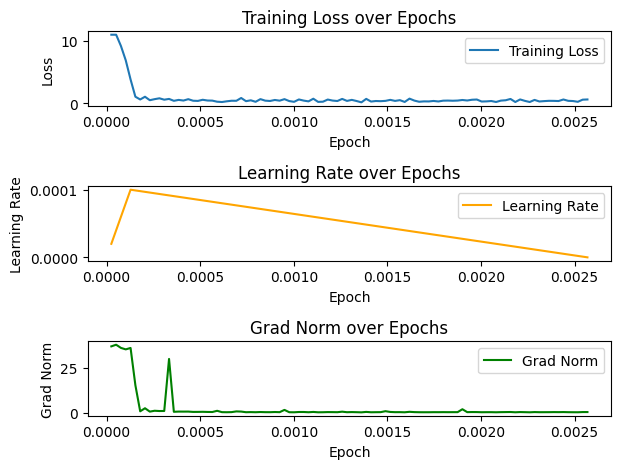

In [124]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in turkishReviews_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 900M

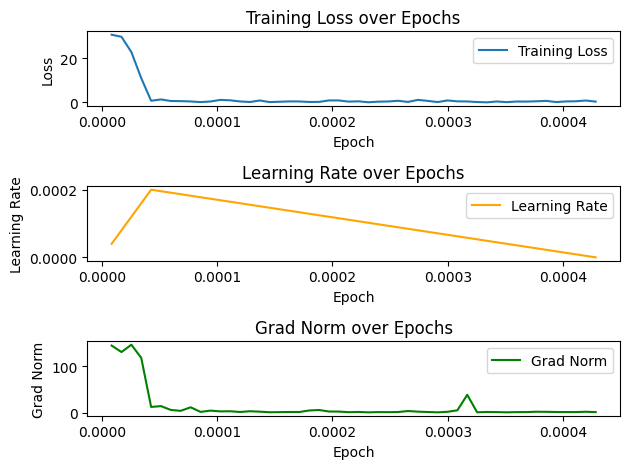

In [123]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_900M_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2

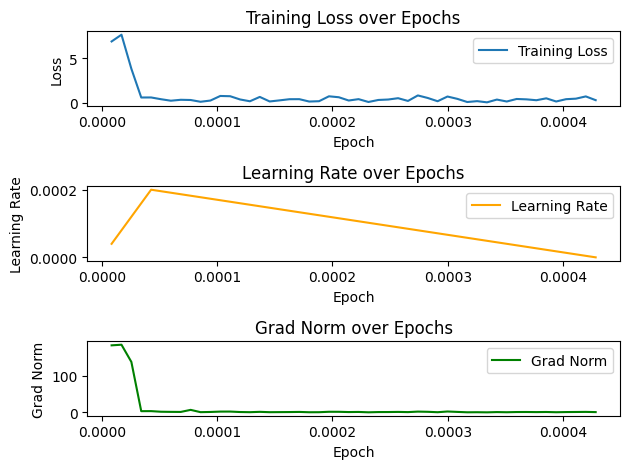

In [122]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 Large

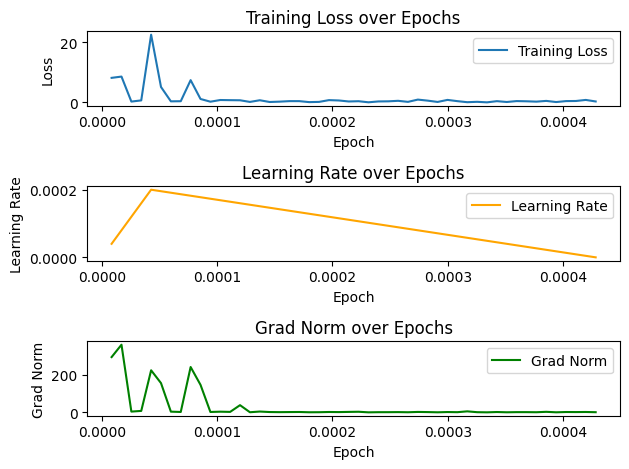

In [126]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_large_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 Medium

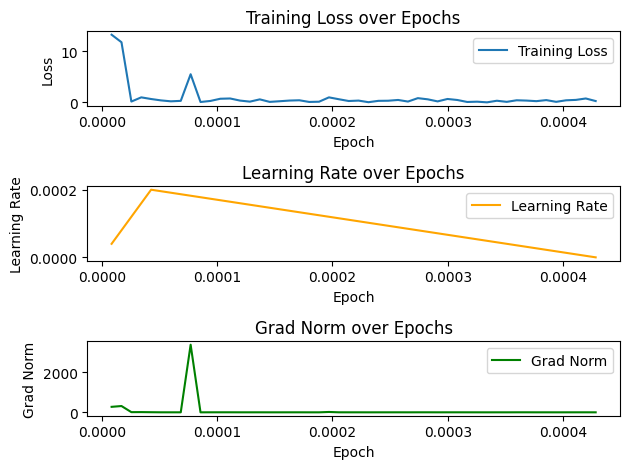

In [127]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_medium_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Kanarya

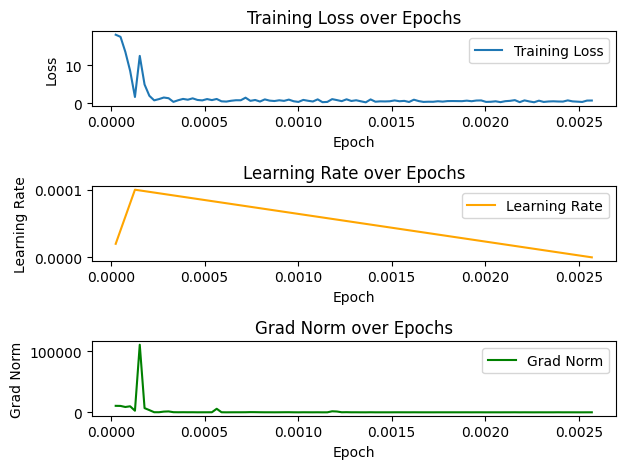

In [128]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in kanarya_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
